<a href="https://colab.research.google.com/github/paulagm12/DSPS_PGalvezMolina/blob/main/HW5_PGalvezMolina/HW5_FitLineToGRBAfterGlow_mcmc_PGalvezMolina_DSPS23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [1]:
import pandas as pd
import pylab as pl
%pylab inline
from sklearn.model_selection import train_test_split


Populating the interactive namespace from numpy and matplotlib


# Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [2]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/main/data/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


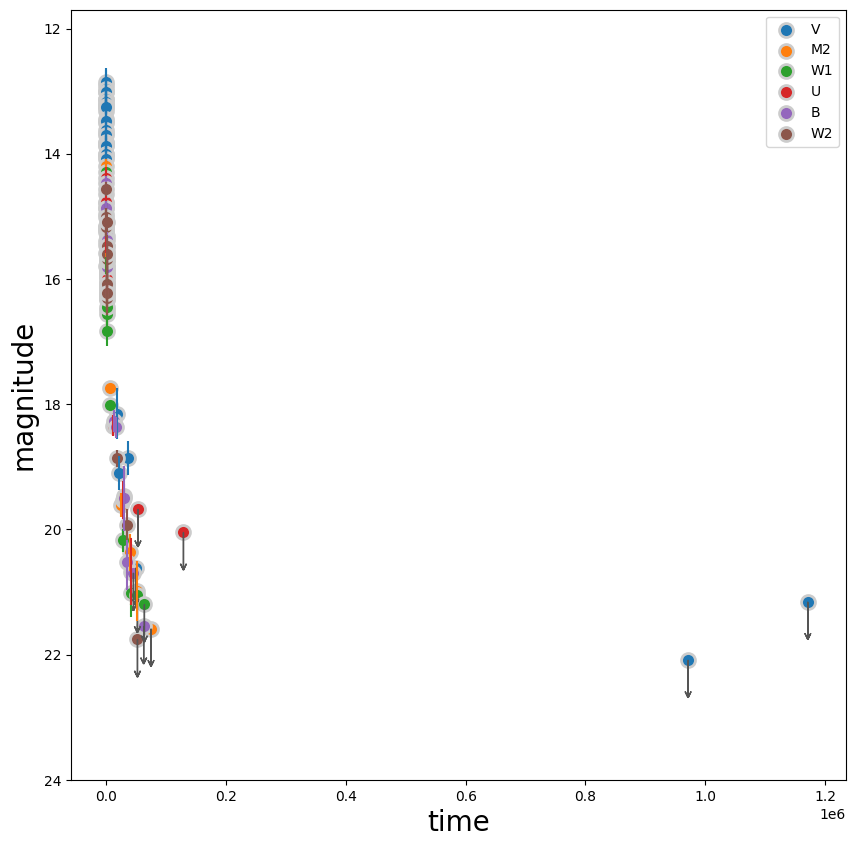

In [3]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);

###  Fig. 0. Magnitude of GRBs from given data set over time.

# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [4]:
grbAG['logtime'] = np.log10(grbAG["time"].values)
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

In [5]:
def plotlogtime(df, models=[]):
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  pl.ylim(24,11.7)
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time", fontsize=20)
  return ax

<Axes: xlabel='log time', ylabel='magnitude'>

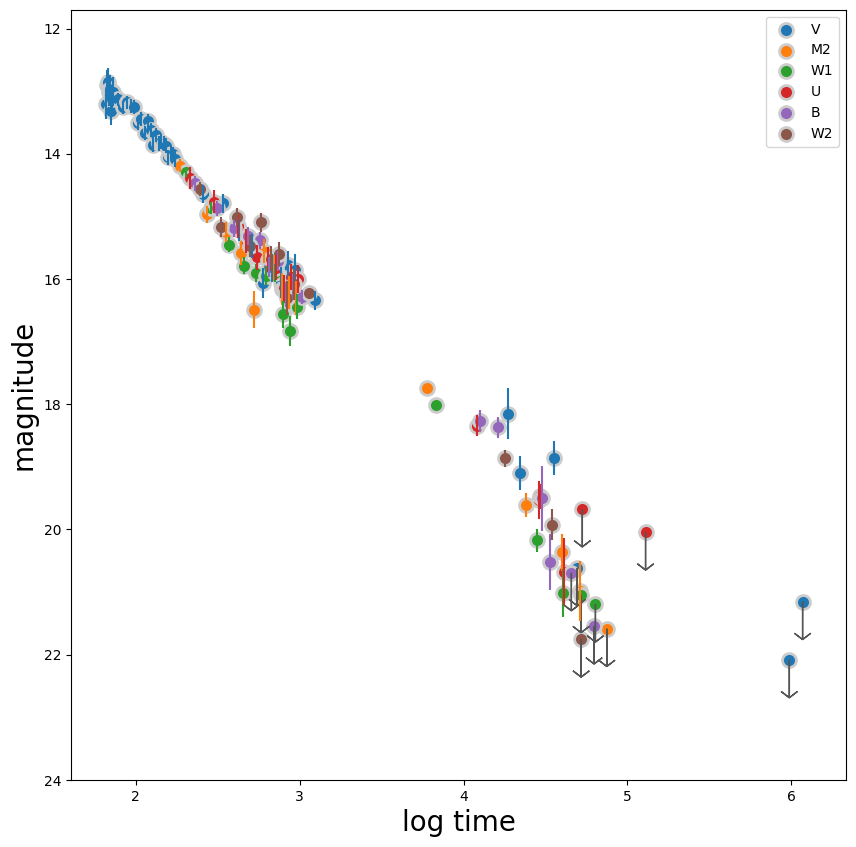

In [6]:
plotlogtime(grbAG)

### Fig. 1. Magnitude of given GRBs at a given time in logarithmic scale.

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

# Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [7]:
x = grbAG[grbAG.upperlimit == 0].logtime.values
X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)),
          x]


y = grbAG.loc[grbAG.upperlimit == 0].mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [8]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```.
To remove the upper limits you can "broadcast" the data: in pandas that looks like

```grbAG.loc[grbAG.upperlimit == 0]```



In [9]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X,y)
print("The best fit parameters from the Normal Equation are intercept: {:.2f} slope {:.2f}.".format(lr.intercept_, lr.coef_[1]))

The best fit parameters from the Normal Equation are intercept: 8.58 slope 2.51.


# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 and L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [10]:
def line(intercept, slope, x):
    return intercept+ slope*x

In [11]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def line(intercept, slope, x):
    return intercept+ slope*x
def l1(args, x, y):
  '''l1 target function: returns value of l1 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L1 sum of absolute value of the difference between prediction and data'''
  intercept, slope = args
  return sum(np.abs(y-line(intercept, slope, x)))


initialGuess = [10,1]

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 26.303317772383874
        x: [ 8.225e+00  2.641e+00]
      nit: 17
      jac: [-1.359e-01 -2.094e+00]
 hess_inv: [[ 1.935e-04 -4.675e-05]
            [-4.675e-05  1.132e-05]]
     nfev: 391
     njev: 125

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64


In [12]:

def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared'''
    intercept, slope = args
    return sum((y-line(intercept, slope, x))**2)

initialGuess = [10,1]

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.82598750072551
        x: [ 8.583e+00  2.512e+00]
      nit: 4
      jac: [ 0.000e+00  2.384e-07]
 hess_inv: [[ 6.254e-02 -2.030e-02]
            [-2.030e-02  7.114e-03]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of L2: slope 8.58, intercept 2.51


In [13]:
l1?


# Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [14]:
def chi2(args, x, y, s):
  intercept, slope = args
  return sum((y-line(intercept, slope, x))**2/s**2)

x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

initialGuess = [10,1]

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 317.420669801309
        x: [ 8.599e+00  2.480e+00]
      nit: 4
      jac: [-3.815e-06  0.000e+00]
 hess_inv: [[ 1.559e-03 -5.429e-04]
            [-5.429e-04  2.017e-04]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of the chi squared: slope 8.60, intercept 2.48


# Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


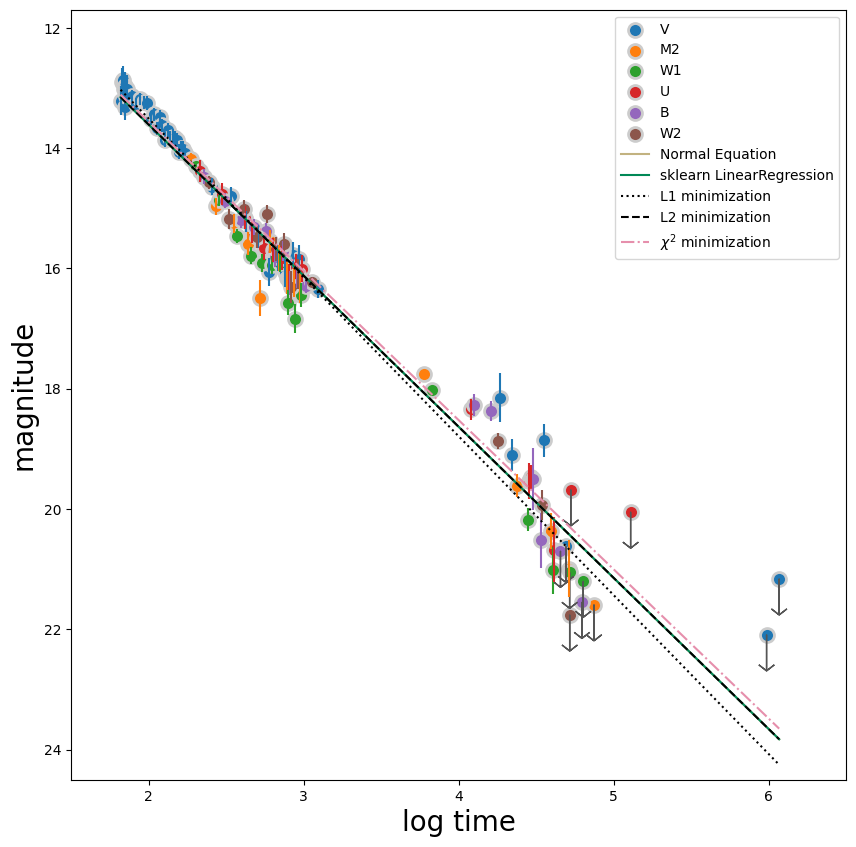

In [15]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);


Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analytically with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.

# HW part 1: redo the sklearn model with a train-test split of the data

- choose the train-test rations that you prefer
- get the score for the model when predicting on the train data and on the test data
- what can you say about the model by comparing the two scores?

In [16]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.25, random_state=42) # This is for the sklearn that needs x to be a 2D array
reg = LinearRegression()
reg.fit(X_train, y_train)
print("The score for the trained data: {:.3f}".format(reg.score(X_train, y_train)))
print("The score for the test data: {:.3f}".format(reg.score(X_test, y_test)))

The score for the trained data: 0.972
The score for the test data: 0.970


# Now try a line to the data with MCMC

# HW part 2: write captions for each figure. The figures are produced by my code. The captions should state:
- what is plotted
- what is noticeable or interesting in the figure



In [17]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.4 MB/s eta 0:00:00


In [18]:
import emcee #import the package

In [19]:
emcee

<module 'emcee' from '/usr/local/lib/python3.10/dist-packages/emcee/__init__.py'>

look at documentation: https://emcee.readthedocs.io/en/stable/

We are implementing Bayes theorem to find the best model parameters: $P(\theta | D) ~ P(D | \theta) * P(\theta)$ or _Posterior ~ Likelihood * Prior_

Since we are maximizing the likelihood, we work in log space because:
- the logarithm is a monotonic function of its argument (meaning where the argument gets bigger its log gets bigger, where it gets smaller its log gets smaller)
- the log is not defined for negative values (log(something < 0) is undefined) but this does not matter because the likelihood is a probability and probabilities are positive defined.



In [20]:
# LINE MODEL
def log_prior(theta):

  """
    Calculate the log prior probability for a linear model with parameters slope and intercept.

    Parameters:
    -----------
    theta : tuple
        A tuple containing two parameters, slope and intercept, of the linear model.

    Returns:
    --------
    float
        The log prior probability of the parameters.

    Notes:
    ------
    The function assigns a prior probability to the parameters of a linear model. It returns 0 if both slope and intercept are greater than 0, indicating that these parameter values are within the acceptable range. If either slope or intercept is non-positive, it returns negative infinity (-np.inf), signifying that such parameter combinations are not allowed.

    This prior serves as a semi-informative constraint: it enforces the requirement that the slope must be positive, and both the slope and intercept should be non-negative since they are related to physical quantities. The function allows for physically meaningful parameter values while disregarding invalid or combinations that are not physically possible.

    """

  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0
  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf


In [21]:
#log likelihood
# This is an educated guess for our data for what the distribution is.
def log_likelihood(theta, x, y, yerr):
  """
    Calculate the log likelihood for a linear model given observed data.

    Parameters:
    -----------
    theta : tuple
        A tuple containing two parameters, slope and intercept, of the linear model.
    x : array-like
        Array of independent variable values (e.g., x-coordinates).
    y : array-like
        Array of observed dependent variable values (e.g., y-coordinates).
    yerr : array-like
        Array of uncertainties (standard deviations) associated with the observed data.

    Returns:
    --------
    float
        The log likelihood of the observed data given the model parameters.

    Notes:
    ------
    The function calculates the log likelihood of a linear model with parameters slope and intercept given the observed data (x, y) and associated uncertainties (yerr).

    The likelihood is computed using the chi-squared formula, which quantifies the agreement between the observed data and the model's predictions, accounting for uncertainties:

    chi2 = sum((y - line(intercept, slope, x))**2 / yerr**2)

    The log likelihood is then obtained by taking the negative sum of the chi-squared values. This formulation is suitable for cases where the uncertainties follow a Gaussian distribution.

    A higher log likelihood indicates a better fit of the model to the data. This likelihood function helps in the parameter estimation and model fitting process, guiding the search for the most probable model parameters that best describe the data.

    """

  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)

In [22]:
#log posterior
def log_posterior(theta, x, y, yerr):
  """
  Calculate the log posterior probability for a linear model with prior constraints.

  Parameters:
  -----------
  theta : tuple
      A tuple containing two parameters, slope and intercept, of the linear model.
  x : array-like
      Array of independent variable values (e.g., x-coordinates).
  y : array-like
      Array of observed dependent variable values (e.g., y-coordinates).
  yerr : array-like
      Array of uncertainties (standard deviations) associated with the observed data.

  Returns:
  --------
  float
      The log posterior probability of the model parameters given the observed data and prior constraints.

  Notes:
  ------
  The function calculates the log posterior probability of a linear model with parameters slope and intercept given the observed data (x, y) and associated uncertainties (yerr).

  The log posterior is computed as the sum of the log prior probability and the log likelihood of the data since by Bayes theorem, posterior ~ likelihood * prior. Thus,

  log_posterior = log_prior(theta) + log_likelihood(theta, x, y, yerr)

  The log prior probability represents prior constraints on the model parameters, ensuring that physically meaningful values are favored. If the parameters fall outside the prior constraints (resulting in a non-finite prior probability), the log posterior is set to negative infinity (-np.inf), indicating that such parameter combinations are not allowed.

  """
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood(theta, x, y, yerr)

In [23]:
#initial guess
ig = [1,10]

In [24]:
#initialize N walkers
nwalkers = 32
ndim = len(ig)

In [25]:
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim) #the starting point for each walker is a small perturbation of the initial guess

In [26]:
pos.shape

(32, 2)

In [27]:
# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, s))

In [28]:
# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:07<00:00, 705.92it/s]


In [29]:
# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

In [30]:
samples.shape

(5000, 32, 2)

In [31]:
# to get statistical properties of the chains I will concatenate the 32 chains. This works _iff_ the chains are independent
# note: the chains are _assumed_ to be independent
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [32]:
mcmc = np.zeros((ndim, 3))
np.percentile( flat_samples[:,1], [16, 50, 84]) # gets 16th, 50th, and 84th percentile

array([8.55910481, 8.59908736, 8.63765606])

In [33]:
#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc

array([[2.46632077, 2.4804642 , 2.49461904],
       [8.55910481, 8.59908736, 8.63765606]])

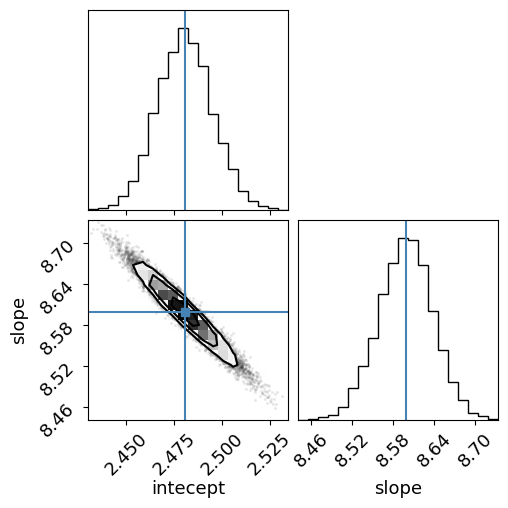

In [34]:
#plotting the likelihood space: the panels are 2D projections of the feature space and 1D marginalized probabilities for each parameters
!pip install corner
import corner
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["intecept", "slope"], truths=mcmc[:,1]);


### Fig. 3. Plot set for the marginalized probability for the log of the posterior distribution to applying a linear fit to the log time vs. magnitude plot of GRB data through MH-MCMC. The top and bottom right panels show the histogram for the intercept and the slope respectively, for running the 5,000 iterations in 32 steps and disregarding the first 100 results. The bottom left shows the scatter plot for the probability distribution of a given pair of intercept,slope in the 2 feature plane. In blue, the median values of the distribution is shown for reference. From their symmetric shape, the distributions appear to be Gaussian, also from the ellopsoidal plot we may determined that the slope and the intercpet are covariant.

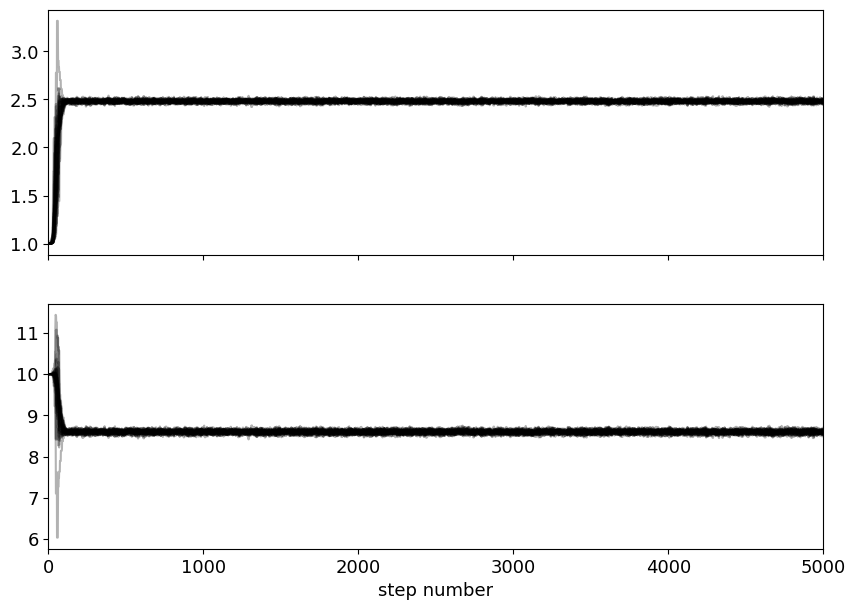

In [35]:
# the chains should be plotted as well. in the slides and in class I discuss what you should expect them to look like
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

### Fig.4. Chains (32) of 5,000 iterations each from them MH-MCMC algorithm to fit a line to the magnitude vs. log time GRB data. It is important to notice how at the begginning the value of the walker changed drastically, but after some iterations the value settled.

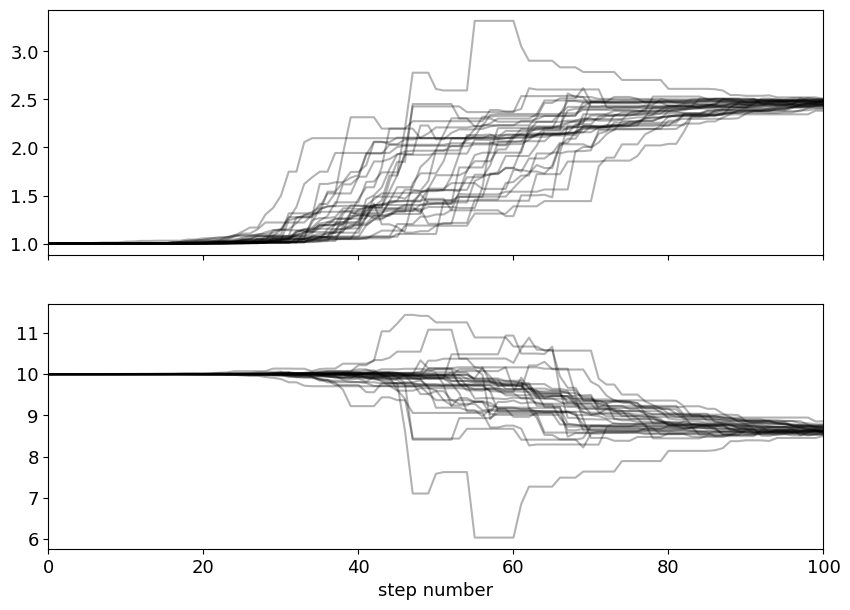

In [36]:
# zoom in: the beginnign of the chane should be cut - this is the burn-in part of the chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

### Fig. 5. Zoom into the first 100 iterations of the chains in Fig. 4. This figure explicitly shows the ambivalent nature of the first iterations and then their "convergence".

In [37]:
# save the mcmc results for later
mcmc_line = mcmc

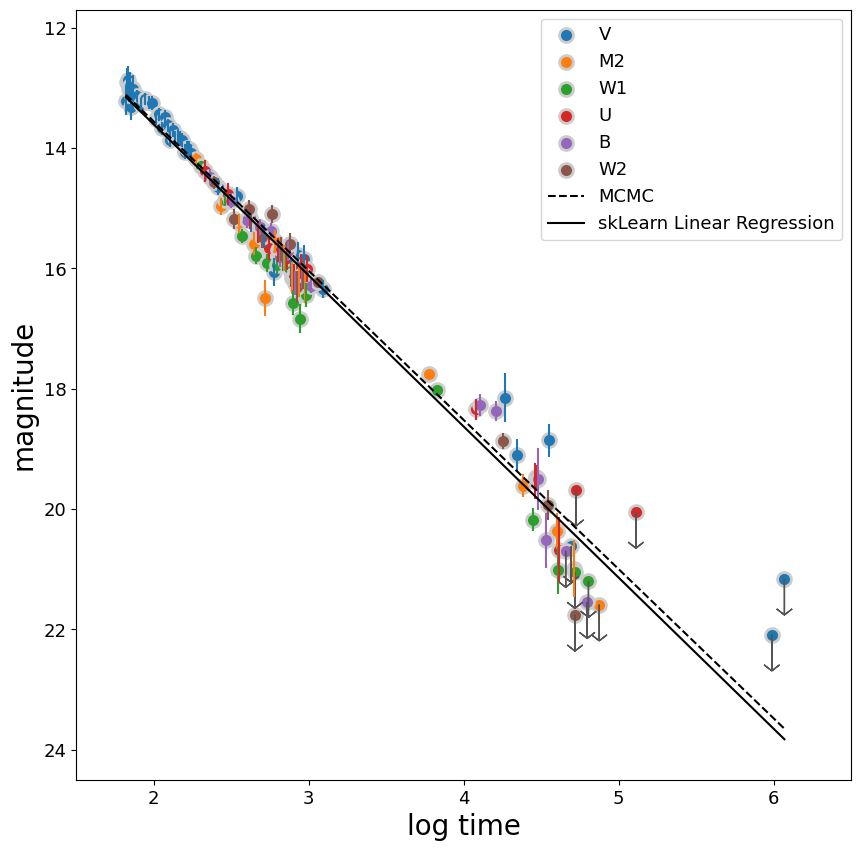

In [180]:
labels = ["intercept","slope"]
ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(grbAG.logtime.values,
        line(mcmc_line[1,1], mcmc_line[0,1], grbAG.logtime), ls="--", c="k",
        label="MCMC")

#with the LinearRegression object I can also do
pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]),
        'k-', label="skLearn Linear Regression")

pl.legend()

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

### Fig. 6. Magnitude of GRB over time in the log scale with a MH-MCMC linear fit (dashed) and a linear fit through SKLearn.

# HW part 3

# Now try a broken power law (BPL) model

A power la is not a good model for GRB afterglows. A broken power law has been known to be a better model and has several physical motivations. In this exercise you will fit a _broke power law_ to the data, which is a more complex and higher dimensional model than the simple line fit we did so far, with MCMC getting best values for the posterior, a complete characterization of the likelihood, and allowing model selection between the line and the power law.

> Here is some info that talks about the power law model and the phsyics of GRB, which you need not know to solve the assignment but you may be interested in.  A broken power law is a power law ($y ~ x^a$) where the power a changes at some point. This can be caused by the presence of two power law processes with different, for example, where one dominates at early time and the other at late times.


>> Here is some more info that explains why we observed the GRB afterglows as broken power laws.
>>Gamma-ray bursts (GRBs) are produced by the collapse of massive stars or the merger of compact objects like neutron stars. The energy of the collapse is highly energetic (Gamma rays) but the emission gets reprocessed as it leaves the system and looses energy becoming detectable in the optical wavelengths. This is called the "optical afterglow of the GRB".
>>The explosion resulting from the collapse generates a highly relativistic outflow of material that moves at a significant fraction of the speed of light.
>> The afterglow emission is primarily produced through synchrotron radiation, where charged particles spiral around magnetic field lines. The radiation produced by synchrotrone follows a power law with an index that depends on the density of the surrounding medium, the Lorentz factor of the outflow, and the magnetic field strength. As the radiation crosses different regions of the system that collapsed these factors change and the powerlaw index changes with them.

>>If the relativistic outflow is highly collimated (a jet) as the jet expands, its emission can be modeled as a power-law light curve, but  where the jet begins to decelerate and spread out the slope of the power law changes. This transition is known as the "jet break" and results in a broken power-law behavior.

>> Some GRBs exhibit late-time flares or additional energy injection from the central engine but we are not modeling this in this exercise.




_BPL model variables:_

$F = \mathrm{flux}$ - note: not magnitude this time! $mag ~ -2.5log10(Flux)$

$t =  \mathrm{time}$ - note: not log time

_BPL model parameters:_


$T_b =  \mathrm{Time~of~break}$

$a_1:  \mathrm{Early~slope}$

$a_2: \mathrm{Late~slope}$

$b:  \mathrm{nuisance~parameters}$

_BPL model_:

in flux space the BPL model is:
$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$

in magnitude space (the data you want to predict is in magnitude and the equation is simple to minimize in log space) that is:

$mag = b - log_{10}\left((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2})\right) $



In [39]:
t = grbAG[grbAG.upperlimit == 0].time.values

In [40]:
t.min(), t.max()

(66, 51257)

# HW part 3 task 1:
create the model `bpl()`, the `log_likelihood()`, `log_prior()` (choose what you want to set your prior to), and `log_posterior()`

In [52]:
def bpl (theta, x):
    """broken power law model
    Input:
      theta: (array like) 4 parameters vector: b, T_b (time of break), a1 (early slope) and a2 (late slope)
      x: (array like) independent variable: magnitude
    Return:
      # model predictions for each x (array like) using the given parameters in theta
    """


    b, T_b, a1, a2 = theta
    return b - np.log10((x/T_b)**(-a1)+(x/T_b)**(-a2))


In [80]:
def log_likelihood_bpl(theta, x, y, yerr):
  b, T_b, a1, a2 = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return np.sum(((y - bpl(theta, x))**2) / yerr**2)


def log_prior_bpl(theta):
  b, T_b, a1, a2 = theta
  if b > 0 and a1 > 0 and a2 > 0 and t.max() > T_b >= t.min(): # I wanted to do here t.max() > T_b >= t.min() but I can't because the prior cannot know anything about my model
    return 0
  # semi informative prior: i know T_b has to be positive because dealing with positive greater than zero numbers, likewise b has to be positive since mags are positive values
  # analogously, if a1 or a2 are negative we might have an integer wich we would take the log from and that would make it positive and might make our flux negative
  return -np.inf

def log_posterior_bpl(theta, x, y, yerr):
  lp = log_prior_bpl(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood_bpl(theta, x, y, yerr)

# HW part 3 task 2:
Find the initial starting point as a stochastic gradient descent minimization of the log likelihood

In [81]:
x_nolog = grbAG[grbAG.upperlimit == 0].time.values

In [82]:
ig = [0.2, 5, 1000, 20]
bpl(ig, x_nolog)

array([22.61147862, 22.74209597, 22.87077817, 22.99758173, 23.12256071,
       23.24576689, 23.36724984, 23.48705712, 24.06249197, 24.60216176,
       25.11025336, 25.59025888, 26.04512143, 26.47734441, 26.88907502,
       27.28216878, 27.65824006, 28.01870214, 28.36479931, 28.69763273,
       29.01818164, 29.32732066, 29.62583422, 29.91442853, 30.19374165,
       30.464352  , 30.72678555, 30.98152198, 31.65743204, 32.3276273 ,
       32.86936911, 33.41730956, 34.0039216 , 34.45299403, 34.91197799,
       35.34792058, 35.73402368, 36.13148666, 36.56451787, 36.90112203,
       37.24959987, 37.58463439, 38.19641005, 38.53960095, 38.66488037,
       38.8087919 , 39.08965344, 39.38082785, 39.62551697, 39.88154068,
       40.16518677, 40.38901792, 40.62378598, 40.85237522, 41.05938147,
       41.35332208, 41.51905961, 41.71093923, 41.91294577, 42.12429171,
       42.30338856, 42.49221968, 42.6900845 , 42.87077817, 43.04778932,
       43.22126507, 43.37930521, 43.54634669, 43.73339865, 43.88

In [83]:
ig = [0.2, 5, 1000, 20]
bounds = [(-np.inf, np.inf), (t.min(), t.max()), (0, np.inf), (0, np.inf)]
#what does the minimize function need to take as arguments?
soln = minimize(log_likelihood_bpl, ig, args=(x_nolog, y, s), bounds=bounds)
soln

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 320.0013818160858
        x: [ 1.311e+01  6.600e+01  1.000e+03  2.478e+00]
      nit: 7
      jac: [ 5.684e-06  4.514e+01  0.000e+00  3.979e-05]
     nfev: 40
     njev: 8
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

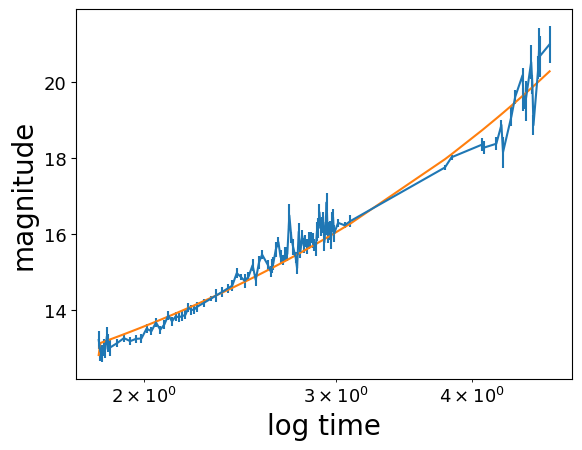

In [181]:
ig = soln.x # the initial guess for the MCMC

# plot the model as it looks with the initial guess values
pl.errorbar(x, y, yerr=s)
pl.plot(x, bpl(ig, x_nolog))
pl.xscale("log")
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);


### Fig. 7. Magnitude over time in log space, resulting from the broken power law using the initial guess of b = 0.2, T_b = 5, a1 = 1000 and a2 = 20.

# HW 3 task 3: optimize the model wit MCMC

- set the emcee hyperparameters
- run the chains
- extract the statistical properties of the chain as the best fit values
- plot the model
- plot the marginalized posteriors of the model parameters

In [138]:
def log_likelihood_bpl(theta, x, y, yerr):
  b, T_b, a1, a2 = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - bpl(theta, x))**2) / yerr**2)


def log_prior_bpl(theta):
  b, T_b, a1, a2 = theta
  if b > 0 and a1 > 0 and a2 > 0 and t.max() > T_b >= t.min(): # I wanted to do here t.max() > T_b >= t.min() but I can't because the prior cannot know anything about my model
    return 0
  # semi informative prior: i know T_b has to be positive because dealing with positive greater than zero numbers, likewise b has to be positive since mags are positive values
  # analogously, if a1 or a2 are negative we might have an integer wich we would take the log from and that would make it positive and might make our flux negative
  return -np.inf

def log_posterior_bpl(theta, x, y, yerr):
  lp = log_prior_bpl(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood_bpl(theta, x, y, yerr)

In [139]:
# set the emcee hyperparameters
nwalkers, ndim = [32, len(ig)]

pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_bpl, args=(x_nolog, y, s))

In [140]:
# run the model
sampler.run_mcmc(pos, 5000, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 12%|█▏        | 599/5000 [00:01<00:07, 600.05it/s]<ipython-input-52-b4561b334b85>:12: RuntimeWarning: overflow encountered in power
  return b - np.log10((x/T_b)**(-a1)+(x/T_b)**(-a2))
100%|██████████| 5000/5000 [00:10<00:00, 471.99it/s]


State([[1.50440419e+01 2.71318076e+02 3.59156085e+00 2.12589783e+00]
 [1.53780915e+01 3.64178000e+02 3.35165088e+00 2.13400977e+00]
 [1.52672454e+01 3.31430654e+02 3.40322499e+00 2.11965038e+00]
 [1.56556601e+01 4.59599033e+02 3.31119114e+00 2.05435118e+00]
 [1.53017243e+01 3.32654433e+02 3.45349251e+00 2.08136268e+00]
 [1.50556408e+01 2.71441519e+02 3.65258236e+00 2.11244737e+00]
 [1.57094289e+01 4.80463874e+02 3.29492687e+00 2.05402426e+00]
 [1.49592569e+01 2.54169689e+02 3.60687482e+00 2.13729133e+00]
 [1.51064127e+01 2.88785867e+02 3.47047986e+00 2.13066266e+00]
 [1.50370129e+01 2.67536909e+02 3.58358310e+00 2.12022564e+00]
 [1.51922028e+01 3.10326812e+02 3.46876460e+00 2.12306127e+00]
 [1.54889424e+01 4.00608069e+02 3.34216026e+00 2.08543018e+00]
 [1.50871574e+01 2.85134356e+02 3.43625660e+00 2.14093770e+00]
 [1.49186618e+01 2.47264047e+02 3.49999077e+00 2.19605539e+00]
 [1.50897119e+01 2.85753979e+02 3.50144966e+00 2.13500467e+00]
 [1.48840421e+01 2.39012753e+02 3.64887203e+00 2.

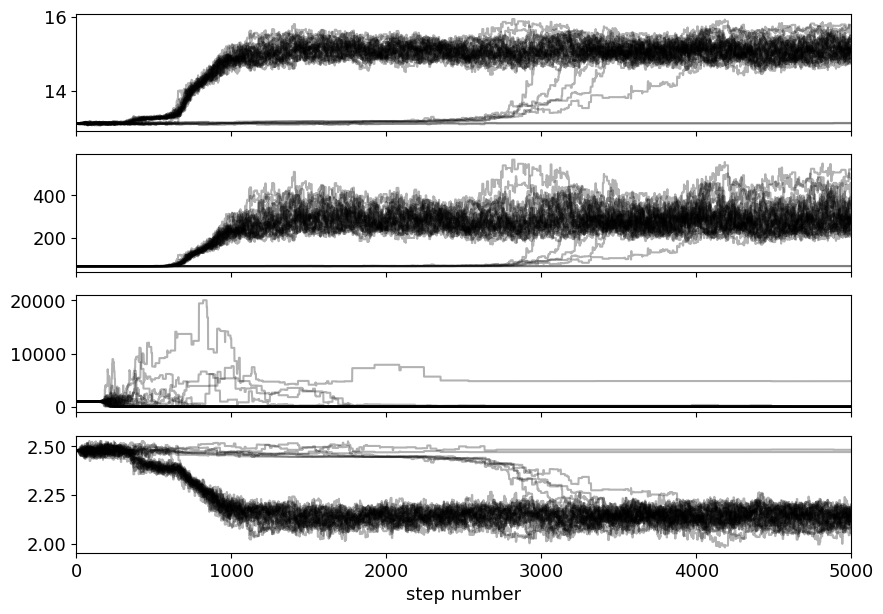

In [185]:
#plot the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
  ax = axes[i]
  ax.plot(samples[:, :, i], "k", alpha=0.3)
  ax.set_xlim(0,  len(samples))
  ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

### Fig. 8. Chains (32) of 5,000 iterations each from them MH-MCMC algorithm to fit a broken power law to the magnitude vs. log time GRB data. The four panels represent the four parameters that the model explored, from top to bottom: b, T_b, a1, a2. For each paramenter, the chains "converged" after the first 1200 iterations.

In [142]:
# get the 16th, 50, and 84th percentiles of the model parameters
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
    mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc[:,1]

array([ 14.93951257, 250.39197149,   3.59789505,   2.1646417 ])

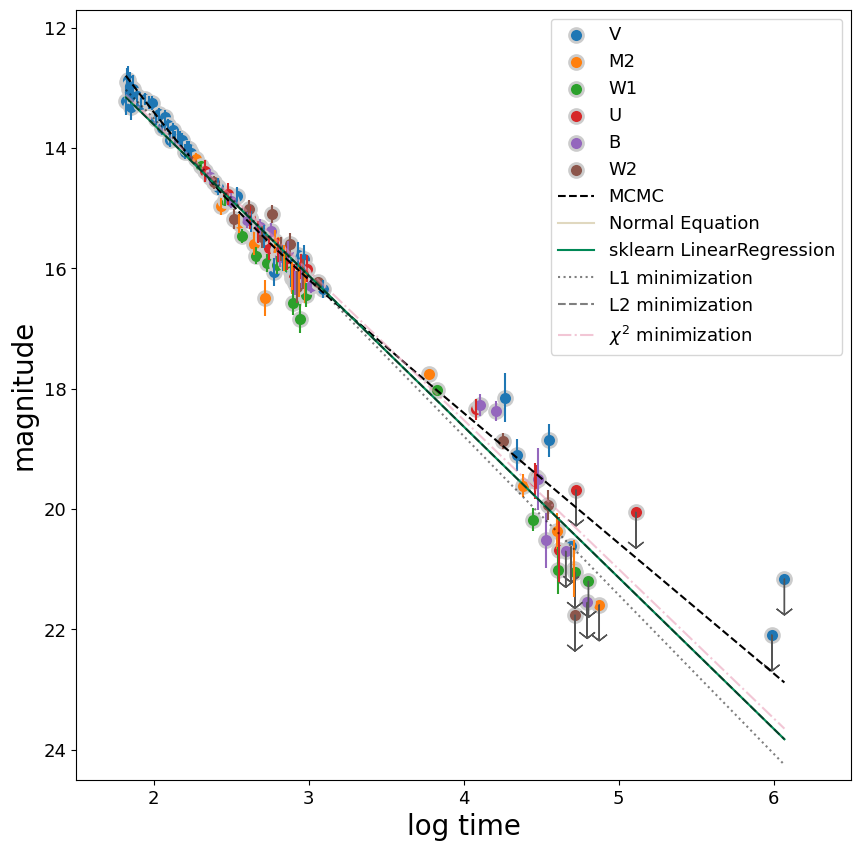

In [187]:
#plot the model
ax = plotlogtime(grbAG)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(grbAG.logtime.values, bpl(mcmc[:,1],
                            grbAG.time.values), ls="--", c="k", label="MCMC")
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],  alpha=0.5,
         label="Normal Equation", ax=ax)
#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':', alpha=0.5,
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--', alpha=0.5,
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.', alpha=0.5,
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
# pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.axvline(np.log10(mcmc[2,1]))
pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

### Fig. 9. Magnitude of GRB over time in the log scale with a MH-MCMC broken power law fit (black dashed), MH-MCMC linear fit (dashed), and other liner fits as explained in the legend. All fits are close in the denser region (up left) but deviate after 10e3 secods. Especially the MH-MCMC fit is the one shifted more upwards than any other.

## plot the marginalized posterior distributions of the parameters

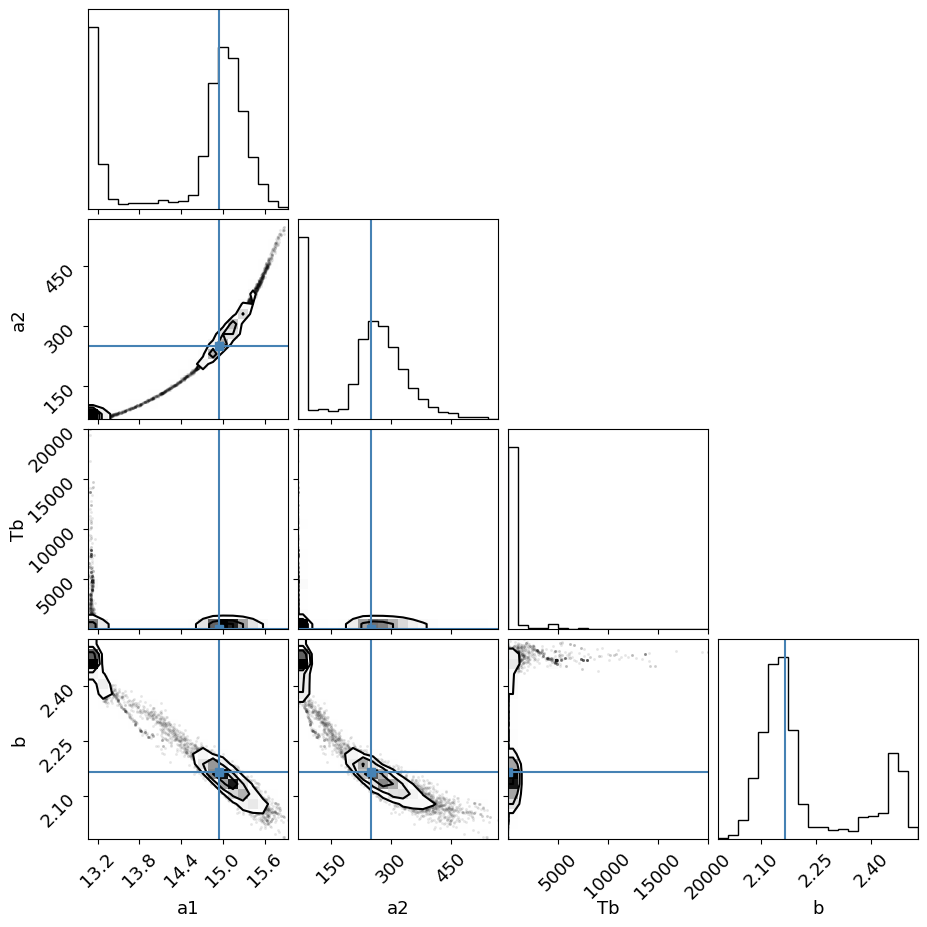

In [146]:

pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["a1", "a2", "Tb", "b"], truths=mcmc[:,1]);



### Fig. 10. Plot set for the marginalized probability for the log of the posterior distribution to applying a broken power law fit to the log time vs. magnitude plot of GRB data through MH-MCMC. The histograms show the probability density for the a1, a2, Tb, and b parameters from top to bottom. The scatter/contour plots show the probability distribution of a given pair of paramenter in the 2 feature plane. In blue, the median values of the distribution is shown for reference. The greatest correlation, is shown in the a1-a2 2-feature plane, as the plot most closely resembles a line.

# HW part 4: Compare the line (as obtained by the MCMC) and broken power law models. For this part of the assignment use the slides in part 2.2 of the current slide deck (slide column 8) https://slides.com/federicabianco/dsps_6#/8. in particular:

- Print the loglikelihood of each model (you can use the log_likelihood function you had written for each)
https://slides.com/federicabianco/dsps_6#/8/1 through https://slides.com/federicabianco/dsps_6#/8/3

- implement the caluculation of the AIC (https://slides.com/federicabianco/dsps_6#/8/4 through 6)
- and BIC (https://slides.com/federicabianco/dsps_6#/8/7)



In [194]:
print("The loglikelihood for the linear model through the MH-MCMC model is {:.2f}".format(log_likelihood(mcmc_line[:,1], x, y, s))) #control the decimal digits!

The loglikelihood for the linear model through the MH-MCMC model is -317.42


In [195]:
print("The loglikelihood for the broken power law model through the MH-MCMC model is {:.2f}".format(log_likelihood_bpl(mcmc[:,1], x_nolog, y, s)))

The loglikelihood for the broken power law model through the MH-MCMC model is -217.60


## Implement the likelihood ration test printing out the likelihood ration statistics

The likelihood-ratio test assesses the goodness of fit of two competing _nested_ statistical models based on the values of the likelihood $L$ where $M1$ is the restricted model (the parameter space is smaller, hence restricted), nested inside $M2$, the full model (the more complex one).

$ \lambda_\mathrm{LR}=-2\ln {\frac {L(M1(\theta_\mathrm{restricted}))}{L(M2(\theta_\mathrm{full}))}}$

This statistics is expexted to be $\chi2$ distributed following a $ch2$ distribution with d.o.f=difference in size of the parameter space in the two models (number of parameters in bpl model - number of parameters in line model).


In [199]:
def like_ratio_statistics(llmin,llmax):
  """
  Calculate the likelihood ratio statistic.

  This function computes the likelihood ratio statistic. It is defined as twice
  the difference in the natural logarithm of the ratio of the likelihood of the
  complex model over the likelihood of the simpler one. Alternatively, it is
  twice the log-likelihood values between the two models.

  Parameters:
  llmin (float): The log-likelihood of the simpler model.
  llmax (float): The log-likelihood of the more complex model.

  Returns:
  float: The likelihood ratio statistic, -2 times the difference between llmax and llmin.

  Example:
  >>> like_ratio_statistics(-100.0, -80.0)
  40.0
  """
  return (-2*(llmax-llmin))

In [202]:
like_ratio_statistics(log_likelihood(mcmc_line[:,1], x, y, s), log_likelihood_bpl(mcmc[:,1], x_nolog, y, s))

-199.64006914111087

## Calculate the AIC and BIC: Aikiki Information Criterion and Bayesian Information Criterion for the comparison of the same two models.


In [226]:
def aic(x, ll, k):
  """
  Calculate the Akaike information criterion (AIC).

  This function computes AIC for model selection. It is defined as
  AIC = -2/N * log(L) + 2/N * k
  where N is the number of variables, L is the likelihood of the data, and k the
  number of features. Alternatively, it is
  AIC = -2/N * ll + 2/N * k
  where ll is the log-likelihood of the data.

  Parameters:
  ll(float): The log-likelihood of the model.
  k (integer): The number of features in the model, must be greater than zero.
  x (array): 1D array of observations.

  Returns:
  float: The AIC for model selection.

  Example:
  >>> aic(-100.0, 2, 1)
  204.0
  """
  N = len(x)
  return (-2/N *ll + 2/N * k)


def bic(x, ll, k):
  """
  Calculate the Bayesian information criterion (BIC).

  This function computes BIC for model selection. It is defined as
  BIC = -2* log(L) + log(N)* k
  where N is the number of variables, L is the likelihood of the data, and k the
  number of features. Alternatively, it is
  BIC = 2*ll + log(N)* k
  where ll is the log-likelihood of the data.

  Parameters:
  ll(float): The log-likelihood of the model.
  k (integer): The number of features in the model, must be greater than zero.
  x (array): 1D array of observations.

  Returns:
  float: The BIC for model selection.

  Example:
  >>> bic(-100.0, 2, 1)
  -200.0
  """
  N = len(x)
  return (2*ll + k * np.log(N))


In [229]:
print("AIC line {0:.2f} - AIC bpl {1:.2f}".format(aic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                      aic(x, log_likelihood_bpl(mcmc[:,1], x_nolog, y, s), 4)))

print("BIC line {0:.2f} - BIC bpl {1:.2f}".format(bic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                      bic(x, log_likelihood_bpl(mcmc[:,1], x_nolog, y, s), 4)))

AIC line 5.92 - AIC bpl 4.10
BIC line -625.48 - BIC bpl -416.47


# Extra Credit
 redefine the chi2 that I have written above to take a n deg polynomial, fit it to the data, compare it to the BPL model